In [ ]:
########################################
# ENTER YOUR NAME AND WISC EMAIL HERE: #
########################################

# Name: ANUBHAV CHOUDHERY
# Email: choudhery@wisc.edu

# Qiskit Fall Fest 2023

![QFF Logo](images/QFF-logo.png)

## Lab C: Dynamic Circuits in Qiskit

- Difficulty: 4/5

- Estimated Time: 75 Minutes

Hi there and welcome to the **Qiskit Fall Fest**! 

As part of the Qiskit Fall Fest, IBM Quantum has created a series of coding challenges for you to work through. We like to call these "labs." Each lab centers on a different topic. Each lab also has a difficulty, and an estimated time, which you can find in the cell above.

There are dozens of different schools participating in the Fall Fest. You're part of a global event that has thousands of students learning about quantum computing. Congrats! Whether you're a beginner or a veteran, we hope you enjoy the Qiskit Fall Fest! We're glad you're here.

This particular Lab introduces the concept of dynamic circuits, and was first featured in the [IBM Quantum Challenge: Spring 2023](https://research.ibm.com/blog/quantum-challenge-spring-2023). If you like this format of Labs that provide a code-based challenge, make sure to join the 2024 Challenge! 

If you've never been part of a Challenge before, it's important to note that you should run every code cell, even if you didn't write any new code within. This makes sure that when you submit your answers by running the grader, everything is up to date. 

In [2]:
## Run this cell to make sure your grader is setup correctly

%set_env QC_GRADE_ONLY=true
%set_env QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com

env: QC_GRADE_ONLY=true
env: QC_GRADING_ENDPOINT=https://qac-grading.quantum-computing.ibm.com


# Part 1: Intro To Dynamic Circuits

According to the [Qiskit textbook,](https://learn.qiskit.org/course/ch-algorithms/quantum-circuits) 
>_"A quantum circuit is a computational routine consisting of coherent quantum operations on qubits ... It is an ordered sequence of quantum gates, measurements and resets, all of which may be conditioned on and use data from the real-time classical computation."_

You might not be familiar with the last part of the definition, but it has everything to do with dynamic circuits. Usually when we talk about quantum circuits, we're referring to _static_ quantum circuits, even if we don't explicitly say it. So what are dynamic circuits?

**Dynamic circuits** are quantum circuits that contain mid-circuit measurements where the results of those measurements are used to condition quantum gates later in the circuit. The ability to condition future quantum operations on the classical measurement results is known as classical feedforward.

Why do we need classical feedforward? An example may help: Consider the conditional reset operation, which may sound familiar if you've ever used the [`reset`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reset.html) operation in Qiskit. While the reset operation is a non-unitary operation that resets the qubit to the zero state no matter the initial state, the conditional reset operation is performed on an already measured qubit to reset it to zero by applying a bit-flip X gate only if the qubit is in the one state, as determined from its measured value. The conditional reset can be a faster and less error-prone way to reset a qubit if it has already been measured.

<center>
<img src="images/sketch-1.png" width="50%">
</center>

Put another way, dynamic circuits are quantum circuits that include control flow, such as 'if' statements and 'while' loops, where the predicates are computed from the results of previous qubit measurements and the conditional operations include quantum gates.

### Hello Dynamic Circuit World

IBM Quantum hardware has already supported mid-circuit measurements and reset for some time. However, adding support for classical feedforward required a significant redesign of the control-systems and the associated software stack. Full support for dynamic circuits was introduced only last year (2022).

In Qiskit, the syntax for programming dynamic circuits has gone through several iterations, and full support has not yet been implemented. Currently, the only way to access the full capabilities of dynamic circuits is to submit programs written in OpenQASM 3. Nevertheless, in this challenge we will be working with what is currently available in Qiskit.

An earlier version of Qiskit introduced the [`c_if()`](https://qiskit.org/documentation/stubs/qiskit.circuit.Instruction.c_if.html) instruction, but this syntax will be deprecated in favor of the more flexible [`if_test()`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html) method of QuantumCircuit, which is the method we'll be mostly using in this challenge.

To get you started, we're going to review a simple example where we'll use this function. We'll build a circuit that demonstrates the conditional reset operation by taking the following steps:

1. Initialize a circuit with 1 qubit and 2 classical bits. ( `q0`, `b0`, and `b1` )
2. Apply a Hadamard gate to `q0`
3. Measure that qubit and save the result in `b0`
4. Begin an `if_test` block conditioned on `b0` being equal to 1.
5. In the `if_test` block, specify the operation to do if the condition is met, in this case, flipping `q0` to 0 state.
6. Measure `q0` again into `b1` to check that we always get 0.

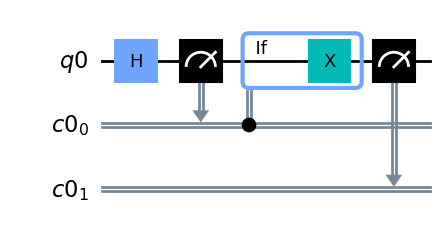

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

Now that our circuit is built, let's run it several times to see if we always get the expected output. The first measurement could be either 0 or 1, but the second measurement should always be 0.

In [4]:
from qiskit_aer import AerSimulator

# initialize the simulator
backend_sim = AerSimulator()

# run the circuit
reset_sim_job = backend_sim.run(qc)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'01': 508, '00': 516}


As expected, the first bit is sometimes 0 and sometimes 1, but the second bit is always 0. Remember that Qiskit uses little-endian bit-ordering, so the right-most bit is the first bit and the left-most bit is the last bit.

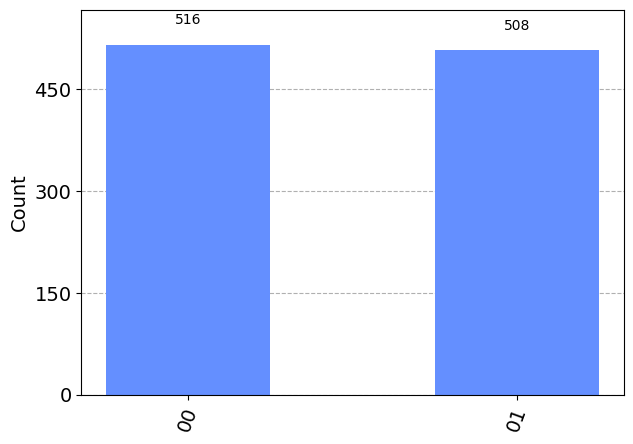

In [5]:
from qiskit.visualization import *

# plot histogram
plot_histogram(reset_sim_counts)

Now you're ready to build your first dynamic circuit!

### Exercise 1

Let's level things up. Your first assignment will be to design a two qubit circuit. In this case, the aim will be to act differently on `q1` depending on the value of `q0`. 

If the measurement on `q0` reads 0, apply an $X$ gate on `q1`. If it reads 1, apply a Hadamard on `q1` instead.

To make the value of `q0` random, the first thing we'll do is apply a Hadamard on that qubit. Next, we'll measure `q0` into `b0`. After that, make the *dynamic magic* happen, and finally, `q1` gets measured.

*For help on this exercise, we encourage you to read the [`if_test()`](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test-1) documentation or work together with your other Qiskit Fall Fest participants.*

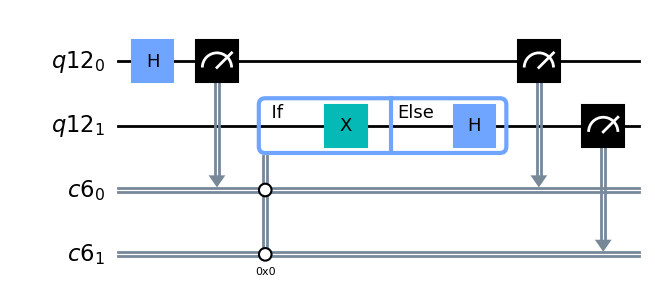

In [11]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)


## Write your code below this line ## 
with qc.if_test((cr,0)) as else_:
    qc.x(1)
with else_:
    qc.h(1)
qc.measure(q0, b0)
## Do not change the code below this line ##


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

Optionally, you can run next cell to check if your circuit behaves as expected. 

*Tip: Think of the possible outcomes of the circuit before running it.*

In [12]:
backend_sim = AerSimulator()

job_1 = backend_sim.run(qc)
result_1 = job_1.result()
counts_1 = result_1.get_counts()

print(f"Counts: {counts_1}")

Counts: {'11': 262, '10': 503, '01': 259}


In [13]:
# Grader Cell: Run this to submit your answer

from qc_grader.challenges.fall_fest23 import grade_ex3b

grade_ex3b(qc)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


## Part 2: Repeat Until Success

Sometimes the outcome of a process is random and the result you get isn't what you wanted. What can you do in this case? Well... you can try again! As long as there is some non-zero probability to get your desired outcome, repeating the process is guaranteed to return the result you wanted... eventually. 

Thankfully, usually only a few repetitions will be needed.

In this section, we will use the repeat-until-success idea to build an $R_X(\theta)$ gate from the finite gate set $\{H,\,X,\,S,\,\text{Toffoli}\}$, where $\theta / \pi$ is an irrational number. Specifically, we will have $\cos\theta = \frac35$. This construction is adapted from Nielsen and Chuang, _Quantum Computation and Quantum Information_, 10<sup>th</sup> anniversary edition, Exercise 4.41, and it demonstrates the universality of the finite gate set given above.

The way the construction works is that we will build a circuit that acts on 3 qubits. One of the qubits is the target qubit and our goal is to perform the $R_X(\theta)$ on this target qubit. The other two qubits are "syndrome" qubits that we will measure and the measurement results will tell us whether our operation was successful or not. If both syndrome qubits read 0, then we will know the gate was performed successfully. Otherwise, we will reset the qubits and try again. We will need dynamic circuits in order to condition the repetitions of the circuit on the measurement results.

### Exercise 2

Your first task of this section will be to create a function that returns that circuit. Here there's an image of how the circuit should look like:

<center>
<img src="images/circuitRx.png">
</center>

To make things easier for you, we'll set up the "base" circuit for you with the required elements. The functions we'll write in this lab will take a circuit as input and modify it in place. Whenever we need a fresh circuit, we'll just make a copy of the base circuit.

In [14]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(controls, target, mid_measure, final_measure)

In the next cell, fill in the `trial` function so that it constructs the circuit by taking the following steps:

1. Apply a Hadamard gate to each qubit of the control register as well as the target qubit.
2. Apply the Toffoli (controlled-controlled-not) gate between the control register and the target qubit. This can be achieved using either the `ccx` method of QuantumCircuit, or by importing and using `CCXGate` from `qiskit.circuit.library`.
3. Apply an $S$ gate to the target qubit.
4. Apply another Toffoli gate, with the same controls and target as Step 2.
5. Again, apply Hadamard to the control and target registers.
6. Measure the control register into the classical register.

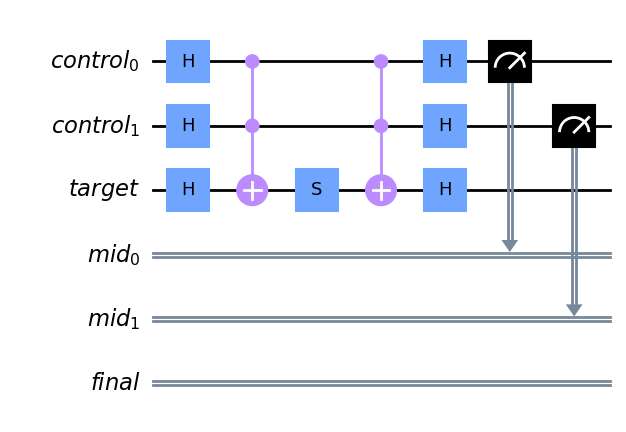

In [16]:
def trial(
    circuit: QuantumCircuit,
    target: QuantumRegister,
    controls: QuantumRegister,
    measures: ClassicalRegister,
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.ccx(0,1,2)
    circuit.s(2)
    circuit.ccx(0,1,2)
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.measure([0,1],[0,1])
    ## Do not change the code below this line ##


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
qc.draw("mpl", cregbundle=False)

In [17]:
# Grader Cell: Run this to submit your answer

from qc_grader.challenges.fall_fest23 import grade_ex3c

grade_ex3c(qc)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


### Exercise 3

Your next task will be to check the measurements. If both measurements of the control bits return $|0\rangle$, the applied gate is $R_X(\theta)$ where $\cos(\theta) = \frac{3}{5}$. If any of the measurements is $|1\rangle$, then the applied gate is simply $X$, which indicates a failure. Therefore, we can tell from the measurements whether we applied the correct gate, without disturbing the coherence of the target qubit. 

If there is a failure, we should reset the qubit and start again.  Since we know what is applied in the case of a failure, we can use this knowledge to perform the reset efficiently, without using a general hardware reset. For the two auxiliary qubits, this is just an $X$ gate conditioned on its respective measurement being $1$.

In the next cell, fill in the `reset_controls` function so that it modifies the circuit by taking the following steps:

1. If the first bit of the `measures` register is equal to 1, apply an $X$ gate to the first control qubit.
2. If the second bit of the `measures` register is equal to 1, apply an $X$ gate to the second control qubit.

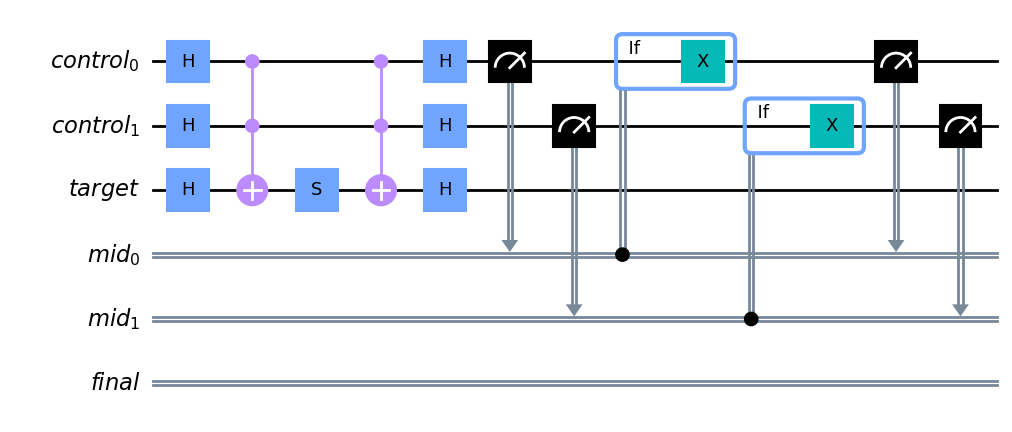

In [18]:
def reset_controls(
    circuit: QuantumCircuit, controls: QuantumRegister, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    with circuit.if_test((measures[0],1)) as else_:
        circuit.x(0)
    with circuit.if_test((measures[1],1)) as else_:
        circuit.x(1)
    ## Do not change the code below this line ##


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
reset_controls(qc, controls, mid_measure)
qc.measure(controls, mid_measure)
qc.draw("mpl", cregbundle=False)

In [19]:
# Grader Cell: Run this to submit your answer

from qc_grader.challenges.fall_fest23 import grade_ex3d

grade_ex3d(qc)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


Now all that is left to do is repeat the execution of the circuit if the conditions weren't satisfied.
In the final exercise, we will need to work around two issues in our current support for dynamic circuits.

The first issue is that Qiskit currently does not support performing any arithmetic or logical operations on classical bits. In particular, it does not support checking that a classical register does *not* have a certain value. In our situation, we need to repeat the trial only if the mid-circuit measurement was *not* the bitstring `00`. To work around this issue, we will create an if statement conditioned on the measurement being equal to `00`, **pass** an empty block, and then use the **else** branch to perform the logic we want for the case that the measurement is *not* `00`.

The second issue is that our hardware currently does not support loops. Therefore, we cannot execute a true repeat-until-success loop. We will work around this issue by simply repeating our trial circuit a fixed number of times.

### Exercise 4

In the code cell below, fill in the `else` block with the logic that should be performed in case the syndrome measurement indicates we need to repeat the trial:

1. Reset the target qubit to the zero state. Remember, we already know that it is in the 1 state.
2. Call the `trial` function on the circuit again.

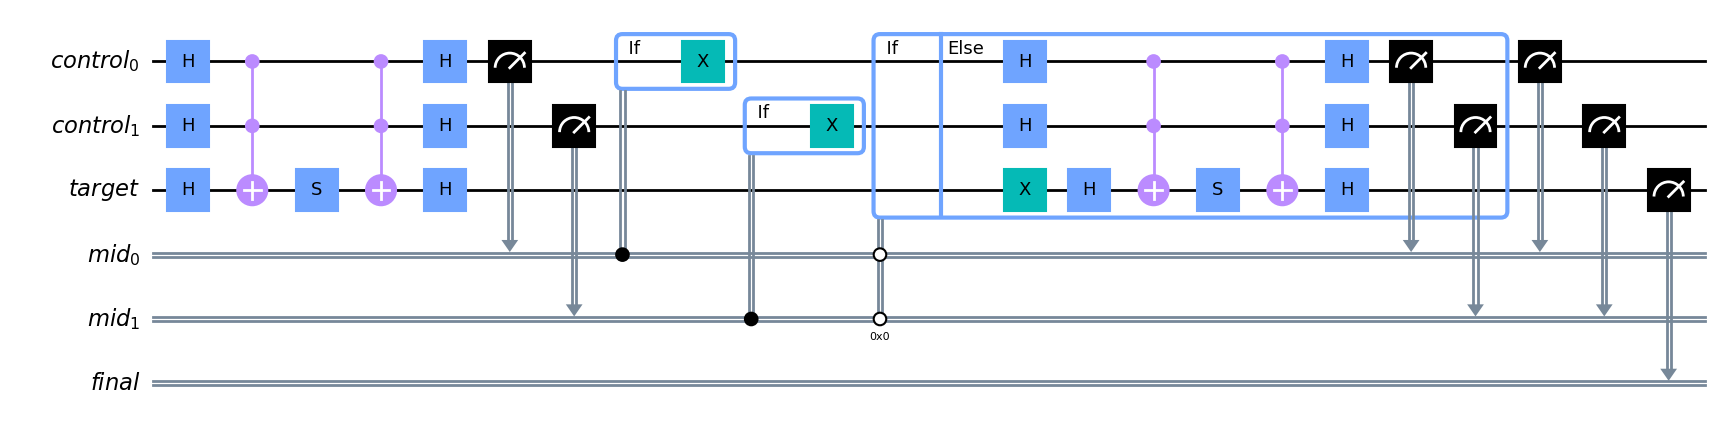

In [22]:
# Set the maximum number of trials
max_trials = 2

# Create a clean circuit with the same structure (bits, registers, etc) as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls are guaranteed to start in the |0> state.
trial(circuit, target, controls, mid_measure)

# Manually add the rest of the trials.  In the future, we will be able to use a dynamic `while` loop to do this, but for now, 
# we statically add each loop iteration with a manual condition check on each one.  
# This involves more classical synchronizations than the while loop, but will suffice for now.

for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        
        
        ## Write your code below this line, making sure it's indented to where this comment begins from ## 
        circuit.x(2)
        trial(circuit, target, controls, mid_measure)
        
        
        ## Do not change the code below this line ##

    
# We need to measure the control qubits again to ensure we get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

In [23]:
# Grader Cell: Run this to submit your answer

from qc_grader.challenges.fall_fest23 import grade_ex3e

grade_ex3e(circuit)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


Let's run the circuit on a simulator.

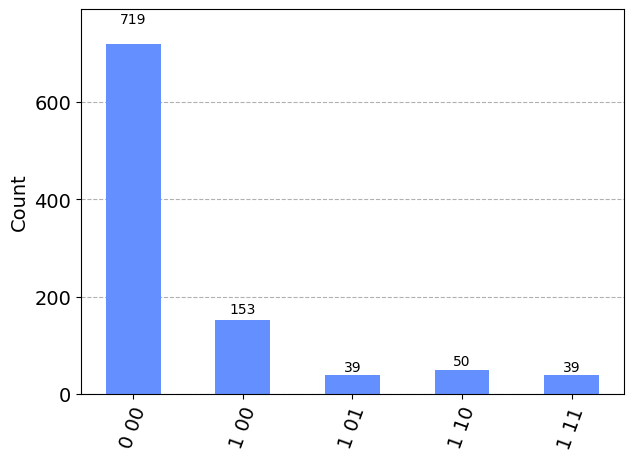

In [24]:
sim = AerSimulator()
job = sim.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

A successful result is one in which the measurements on the two controls end in the `00` state. If you're having trouble, we encourage you to post about your results on the Discord Channel, and try to understand in collaboration with other participants what your results mean and why you are getting them.

## Congratulations!

You've made it to the end of the last lab! Congrats! Enjoy the Qiskit Fall Fest, and learn more at qiskit.org